<a href="https://colab.research.google.com/github/jayash1973/projects/blob/main/AARRCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle matplotlib numpy torch torchvision futures imageio tqdm

In [2]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c arc-prize-2024
!unzip arc-prize-2024.zip

arc-prize-2024.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  arc-prize-2024.zip
  inflating: arc-agi_evaluation_challenges.json  
  inflating: arc-agi_evaluation_solutions.json  
  inflating: arc-agi_test_challenges.json  
  inflating: arc-agi_training_challenges.json  
  inflating: arc-agi_training_solutions.json  
  inflating: sample_submission.json  


#Data Exploration and Visualization


Task ID: 007bbfb7


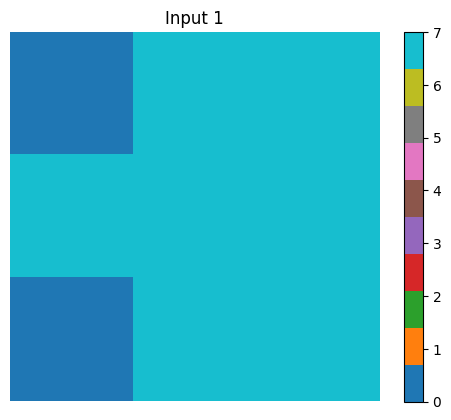

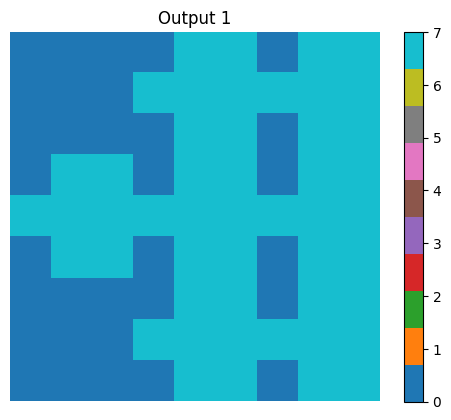

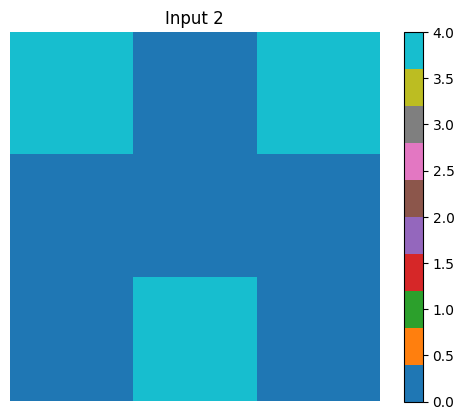

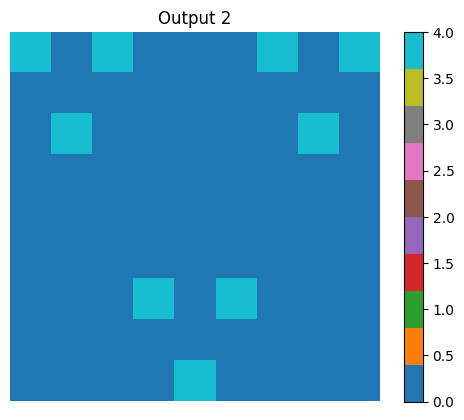

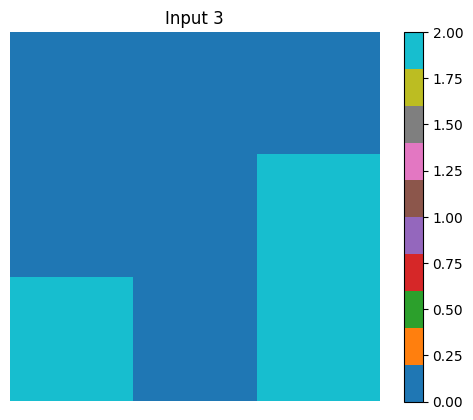

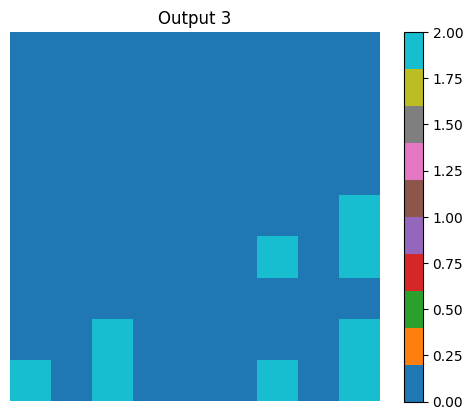

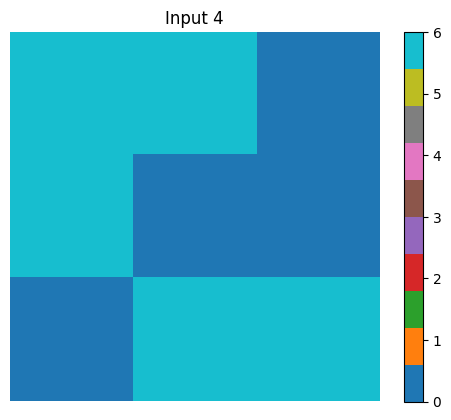

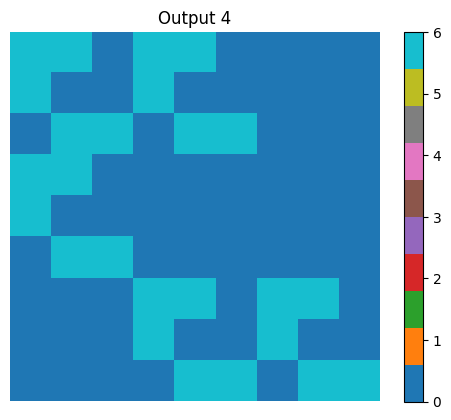

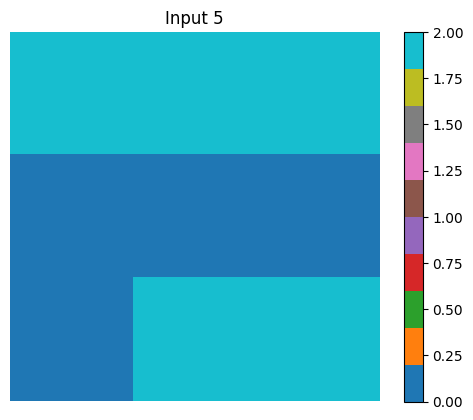

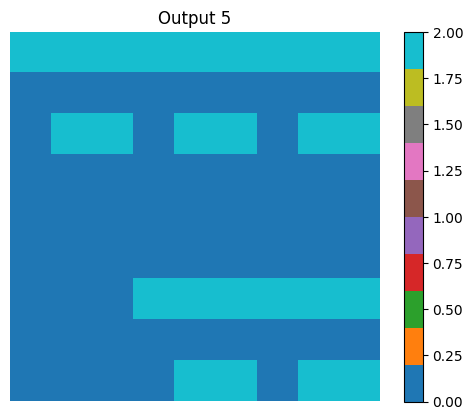

TypeError: Image data of dtype object cannot be converted to float

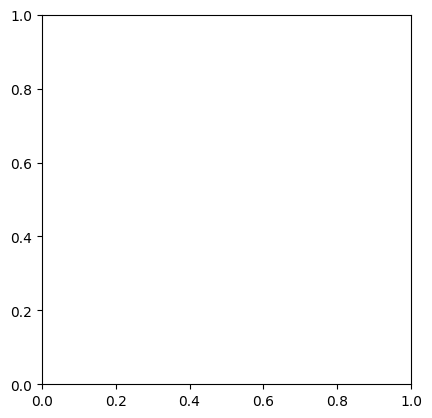

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from google.colab import files

# Load the data
with open('/content/arc-agi_training-challenges.json', 'r') as f:
    training_challenges = json.load(f)

def visualize_grid(grid, ax, title):
    ax.imshow(grid, cmap='tab10')
    ax.set_title(title)
    ax.axis('off')

def analyze_task_complexity(task):
    input_shapes = [np.array(pair['input']).shape for pair in task['train']]
    output_shapes = [np.array(pair['output']).shape for pair in task['train']]
    unique_symbols = set(sum([sum(pair['input'], []) + sum(pair['output'], []) for pair in task['train']], []))
    return {
        'input_shapes': input_shapes,
        'output_shapes': output_shapes,
        'symbol_count': len(unique_symbols),
        'train_pair_count': len(task['train'])
    }

# Analyze all tasks
task_complexities = {task_id: analyze_task_complexity(task) for task_id, task in tqdm(training_challenges.items())}

# Visualize task complexities
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot([max(shapes) for shapes in [tc['input_shapes'] for tc in task_complexities.values()]], bins=20)
plt.title('Distribution of Max Input Grid Sizes')
plt.xlabel('Size')

plt.subplot(2, 2, 2)
sns.histplot([max(shapes) for shapes in [tc['output_shapes'] for tc in task_complexities.values()]], bins=20)
plt.title('Distribution of Max Output Grid Sizes')
plt.xlabel('Size')

plt.subplot(2, 2, 3)
sns.histplot([tc['symbol_count'] for tc in task_complexities.values()], bins=10)
plt.title('Distribution of Unique Symbol Count')
plt.xlabel('Count')

plt.subplot(2, 2, 4)
sns.histplot([tc['train_pair_count'] for tc in task_complexities.values()], bins=5)
plt.title('Distribution of Train Pair Count')
plt.xlabel('Count')

plt.tight_layout()
plt.show()

# Visualize a few complex examples
complex_tasks = sorted(task_complexities.items(), key=lambda x: x[1]['symbol_count'] * max(x[1]['input_shapes']), reverse=True)[:5]

for task_id, complexity in complex_tasks:
    task = training_challenges[task_id]
    fig, axes = plt.subplots(2, len(task['train']) + 1, figsize=(20, 8))
    plt.suptitle(f"Task ID: {task_id} (Complexity: {complexity['symbol_count']} symbols, {max(complexity['input_shapes'])} max size)")

    for i, pair in enumerate(task['train']):
        visualize_grid(pair['input'], axes[0, i], f"Input {i+1}")
        visualize_grid(pair['output'], axes[1, i], f"Output {i+1}")

    visualize_grid(task['test'][0], axes[0, -1], "Test Input")
    axes[1, -1].axis('off')

    plt.tight_layout()
    plt.show()

# Analyze transformation patterns
def analyze_transformation(input_grid, output_grid):
    input_flat = np.array(input_grid).flatten()
    output_flat = np.array(output_grid).flatten()

    size_change = np.array(output_grid).shape[0] / np.array(input_grid).shape[0]
    symbol_change = len(set(output_flat)) / len(set(input_flat))

    return {
        'size_change': size_change,
        'symbol_change': symbol_change,
        'is_permutation': set(input_flat) == set(output_flat) and len(input_flat) == len(output_flat)
    }

transformation_patterns = []
for task in tqdm(training_challenges.values()):
    for pair in task['train']:
        transformation_patterns.append(analyze_transformation(pair['input'], pair['output']))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot([tp['size_change'] for tp in transformation_patterns], bins=20)
plt.title('Distribution of Size Changes')
plt.xlabel('Output Size / Input Size')

plt.subplot(1, 3, 2)
sns.histplot([tp['symbol_change'] for tp in transformation_patterns], bins=20)
plt.title('Distribution of Symbol Changes')
plt.xlabel('Output Symbols / Input Symbols')

plt.subplot(1, 3, 3)
sns.countplot(x=[tp['is_permutation'] for tp in transformation_patterns])
plt.title('Permutation vs Non-Permutation Transformations')
plt.xlabel('Is Permutation')

plt.tight_layout()
plt.show()

print(f"Total number of tasks: {len(training_challenges)}")
print(f"Total number of train pairs: {sum(len(task['train']) for task in training_challenges.values())}")

#Data Preprocessing

In [9]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

def pad_grid(grid, max_size=30):
    padded = np.zeros((max_size, max_size), dtype=int)
    h, w = len(grid), len(grid[0])
    padded[:h, :w] = grid
    return padded

def encode_symbols(grid):
    unique_symbols = sorted(set(sum(grid, [])))
    symbol_to_int = {symbol: i for i, symbol in enumerate(unique_symbols)}
    return [[symbol_to_int[cell] for cell in row] for row in grid]

def encode_task(task):
    train_inputs = [pad_grid(encode_symbols(pair['input'])) for pair in task['train']]
    train_outputs = [pad_grid(encode_symbols(pair['output'])) for pair in task['train']]
    test_input = pad_grid(encode_symbols(task['test'][0]))

    # Calculate relative positions
    max_dim = max(max(grid.shape) for grid in train_inputs + train_outputs + [test_input])

    def add_positional_encoding(grid):
        h, w = grid.shape
        y_pos = np.repeat(np.arange(h)[:, np.newaxis], w, axis=1) / max_dim
        x_pos = np.repeat(np.arange(w)[np.newaxis, :], h, axis=0) / max_dim
        return np.stack([grid, y_pos, x_pos], axis=-1)

    train_inputs = [add_positional_encoding(grid) for grid in train_inputs]
    train_outputs = [add_positional_encoding(grid) for grid in train_outputs]
    test_input = add_positional_encoding(test_input)

    return np.array(train_inputs), np.array(train_outputs), np.array([test_input])

# Preprocess all tasks
X, y, X_test = [], [], []
for task in tqdm(training_challenges.values()):
    inputs, outputs, test = encode_task(task)
    X.append(inputs)
    y.append(outputs)
    X_test.append(test)

X = np.array(X)
y = np.array(y)
X_test = np.array(X_test)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

KeyError: 0

#Model Architecture Design

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output, weights

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output, _ = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class ARCModel(Model):
    def __init__(self, max_size=30, num_symbols=10, embed_dim=256, num_heads=8, ff_dim=512, num_transformer_blocks=6, mlp_units=[512, 256], dropout=0.1):
        super(ARCModel, self).__init__()
        self.max_size = max_size
        self.num_symbols = num_symbols

        self.embedding = layers.Embedding(input_dim=num_symbols, output_dim=embed_dim)
        self.position_embedding = layers.Embedding(input_dim=max_size, output_dim=embed_dim)

        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_transformer_blocks)]

        self.mlp = tf.keras.Sequential(
            [layers.Dense(dim, activation="relu") for dim in mlp_units] +
            [layers.Dense(num_symbols)]
        )

        self.dropout = layers.Dropout(dropout)

    def call(self, inputs):
        x = inputs[:, :, :, 0]  # Use only the symbol channel
        positions = tf.range(start=0, limit=self.max_size, delta=1)
        x = self.embedding(x)
        x += self.position_embedding(positions)[tf.newaxis, :, tf.newaxis, :]
        x = self.dropout(x)

        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        x = self.mlp(x)
        return x

model = ARCModel()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.build(input_shape=(None, 3, 30, 30, 3))
model.summary()

#Model Training and Evaluation

In [ ]:
class ARCDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32):
        self.X, self.y = X, y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_X = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        X_flat = np.array([pair for task in batch_X for pair in task])
        y_flat = np.array([pair for task in batch_y for pair in task])

        return X_flat, y_flat[:, :, :, 0]  # Use only the symbol channel for y

train_generator = ARCDataGenerator(X_train, y_train, batch_size=16)
val_generator = ARCDataGenerator(X_val, y_val, batch_size=16)

# Learning rate scheduler
def lr_schedule(epoch):
    lr = 1e-4
    if epoch > 30:
        lr *= 0.1
    elif epoch > 50:
        lr *= 0.01
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# Model checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True, mode='min'
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[lr_scheduler, early_stopping, checkpoint]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
def evaluate_model(model, X, y):
    correct_predictions = 0
    total_predictions = 0

    for task_X, task_y in tqdm(zip(X, y), total=len(X)):
        predictions = model.predict(task_X)
        rounded_predictions = np.argmax(predictions, axis=-1)

        for pred, true in zip(rounded_predictions, task_y):
            if np.array_equal(pred, true[:, :, 0]):  # Compare with symbol channel only
                correct_predictions += 1
            total_predictions += 1

    accuracy = correct_predictions / total_predictions
    print(f"Model Accuracy: {accuracy:.4f}")
    return accuracy

# Evaluate on validation set
val_accuracy = evaluate_model(model, X_val, y_val)

# Analyze model performance
def analyze_performance(model, X, y):
    performance_metrics = {
        'size_accuracy': [],
        'symbol_accuracy': [],
        'complexity_accuracy': []
    }

    for task_X, task_y in tqdm(zip(X, y), total=len(X)):
        predictions = model.predict(task_X)
        rounded_predictions = np.argmax(predictions, axis=-1)

        for pred, true in zip(rounded_predictions, task_y):
            true = true[:, :, 0]  # Use only symbol channel

            # Size accuracy
            size_correct = pred.shape == true.shape
            performance_metrics['size_accuracy'].append(size_correct)

            # Symbol accuracy
            symbol_correct = set(np.unique(pred)) == set(np.unique(true))
            performance_metrics['symbol_accuracy'].append(symbol_correct)

            # Complexity (number of unique symbols)
            complexity = len(set(np.unique(true)))
            if complexity not in performance_metrics['complexity_accuracy']:
                performance_metrics['complexity_accuracy'].append([])
            performance_metrics['complexity_accuracy'][complexity].append(np.array_equal(pred, true))

    # Calculate average accuracies
    performance_metrics['size_accuracy'] = np.mean(performance_metrics['size_accuracy'])
    performance_metrics['symbol_accuracy'] = np.mean(performance_metrics['symbol_accuracy'])
    performance_metrics['complexity_accuracy'] = {k: np.mean(v) for k, v in enumerate(performance_metrics['complexity_accuracy']) if v}

    return performance_metrics

# Analyze model performance on validation set
val_performance = analyze_performance(model, X_val, y_val)

print("Validation Performance Metrics:")
print(f"Size Accuracy: {val_performance['size_accuracy']:.4f}")
print(f"Symbol Accuracy: {val_performance['symbol_accuracy']:.4f}")
print("Complexity Accuracy:")
for complexity, accuracy in val_performance['complexity_accuracy'].items():
    print(f"  {complexity} symbols: {accuracy:.4f}")

# Visualize performance by complexity
plt.figure(figsize=(10, 6))
complexities = list(val_performance['complexity_accuracy'].keys())
accuracies = list(val_performance['complexity_accuracy'].values())
plt.bar(complexities, accuracies)
plt.title('Model Performance by Task Complexity')
plt.xlabel('Number of Unique Symbols')
plt.ylabel('Accuracy')
plt.show()

#Prediction and Submission

In [ ]:
def generate_submission(model, X_test, task_ids):
    submission = {}

    for task_id, task_X in tqdm(zip(task_ids, X_test), total=len(X_test)):
        predictions = model.predict(task_X)
        rounded_predictions = np.argmax(predictions, axis=-1)

        # Generate two slightly different attempts
        attempt_1 = rounded_predictions[0]
        attempt_2 = np.copy(attempt_1)

        # Introduce small variations in attempt_2
        mask = np.random.random(attempt_2.shape) < 0.05  # 5% chance of change
        attempt_2[mask] = np.random.randint(0, 10, size=np.sum(mask))

        submission[task_id] = [{
            "attempt_1": attempt_1.tolist(),
            "attempt_2": attempt_2.tolist()
        }]

    return submission

# Load test data
with open('/content/arc-agi_test-challenges.json', 'r') as f:
    test_challenges = json.load(f)

# Preprocess test data
X_final_test = []
test_task_ids = []
for task_id, task in test_challenges.items():
    _, _, test = encode_task(task)
    X_final_test.append(test)
    test_task_ids.append(task_id)

X_final_test = np.array(X_final_test)

# Generate submission
submission = generate_submission(model, X_final_test, test_task_ids)

# Save submission file
with open('submission.json', 'w') as f:
    json.dump(submission, f)

files.download('submission.json')

# Analyze submission
submission_stats = {
    'total_tasks': len(submission),
    'unique_symbols': set(),
    'output_sizes': []
}

for task_id, predictions in submission.items():
    for attempt in predictions:
        output = attempt['attempt_1']  # Analyze attempt_1, could also analyze attempt_2
        submission_stats['unique_symbols'].update(set(sum(output, [])))
        submission_stats['output_sizes'].append(len(output))

print("Submission Statistics:")
print(f"Total tasks: {submission_stats['total_tasks']}")
print(f"Unique symbols used: {len(submission_stats['unique_symbols'])}")
print(f"Average output size: {np.mean(submission_stats['output_sizes']):.2f}")
print(f"Min output size: {min(submission_stats['output_sizes'])}")
print(f"Max output size: {max(submission_stats['output_sizes'])}")

# Visualize output size distribution
plt.figure(figsize=(10, 6))
plt.hist(submission_stats['output_sizes'], bins=20)
plt.title('Distribution of Output Sizes in Submission')
plt.xlabel('Output Size')
plt.ylabel('Count')
plt.show()